# Asennusmäärän ennustaminen


Tässä mallissa ennustetaan vuosi puolen vuoden syötteellä. Opetusaineisto valitaan siten, että sen mukana ei mene dataa syötteen tai ennusteen kattavalta jaksolta.

## Kirjastot

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import importlib.util
import sys
file_path = "../../Tehtava-03/preprocessor.py"; module_name = "preprocessor"; spec = importlib.util.spec_from_file_location(module_name, file_path)
esik = importlib.util.module_from_spec(spec); sys.modules[module_name] = esik; spec.loader.exec_module(esik)


## Esikäsittelijän ajaminen

In [2]:
cols = ['installation_date']
df_all = esik.esik(cols)


## Luodaan aikasarja

Aikasarjan indeksinä on kuukausi ja arvona kaikkien kyseisen kuukauden aikana tehtyjen asennusten määrä.

In [3]:
df = df_all.copy()
df['year-month'] = df['installation_date'].dt.strftime('%Y-%m')


In [4]:
value_counts_df = df['year-month'].value_counts().sort_index()
value_counts_df = pd.DataFrame({'year-month': value_counts_df.index, 'count': value_counts_df})
month_period = pd.period_range(start='1998-01-01', end='2019-12-01', freq='M').strftime('%Y-%m')
month = pd.DataFrame(data=month_period, columns=['year-month'], dtype='object')
merged = month.merge(value_counts_df, how='left', on='year-month')
df_year_month = merged.fillna(0)
df_year_month.index = month_period
display(df_year_month)


year-month    count
1998-01    1998-01      1.0
1998-02    1998-02      1.0
1998-03    1998-03      0.0
1998-04    1998-04      1.0
1998-05    1998-05      2.0
...            ...      ...
2019-08    2019-08  13816.0
2019-09    2019-09  13286.0
2019-10    2019-10  13239.0
2019-11    2019-11  13587.0
2019-12    2019-12  15062.0

[264 rows x 2 columns]

## Muokataan ja valitaan data mallia varten

Tehdään aluksi pohjalle df, jossa on mukana koko data. Myöhemmin määritellään opetusaineisto ja mallin ajoon syöte sekä ennustettava jakso.

Tehdään valinta käytetäänkö ennustuksessa liukuvaa keskiarvoa vai asennusmääriä sellaisenaan.

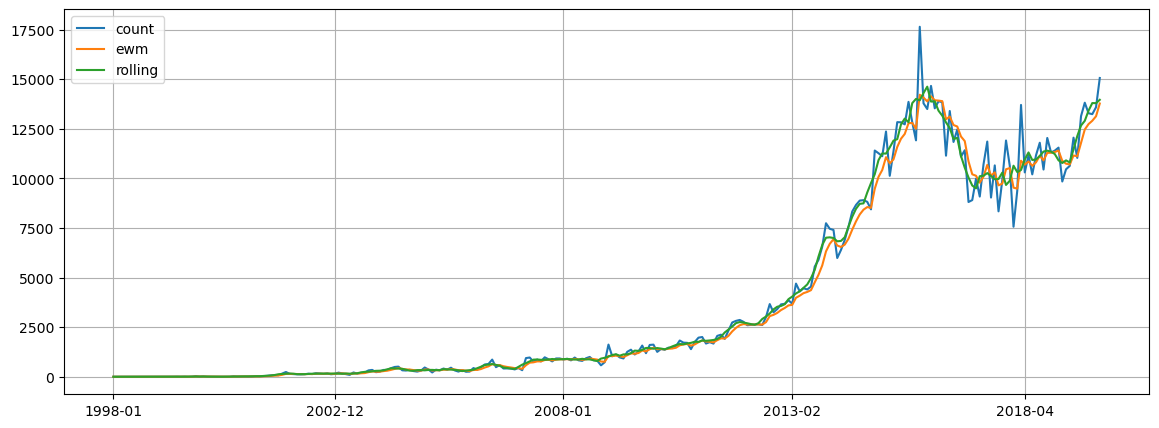

In [5]:
df = df_year_month.copy()

# Vertailut
df['ewm_count'] = df['count'].ewm(com=2).mean()
df['rolling_count'] = df['count'].rolling(5, min_periods=3, center=True).mean()

# Valitaan ajanjakso
start = 1998
n_years = 22


a = start - 1998
b = a + n_years
a = a * 12
b = b * 12
df = df.iloc[a:b,:]

# Piirto
def format_date(x1, pos=None):
  N = len(df)
  thisind = np.clip(int(x1 + 0.5), 0, N - 1)
  return df['year-month'].iloc[thisind]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df['year-month'], df['count'], label='count')
ax.plot(df['year-month'], df['ewm_count'], label='ewm')
ax.plot(df['year-month'], df['rolling_count'],  label='rolling')
if n_years > 2:
  locator = mdates.AutoDateLocator(maxticks=8)
  ax.xaxis.set_major_locator(locator)
  ax.xaxis.set_major_formatter(format_date)
else:
  fig.autofmt_xdate()
ax.legend()
ax.grid()
plt.show()


Valitaan liukuva keskiarvo, koska seuraa paremmin oikeaa käyrää ja pyöristää jonkin verran.

In [6]:
df['count'] = df['rolling_count']
df.drop(['ewm_count', 'rolling_count'], axis=1, inplace=True)
df_ML = df.copy()
print("df_ML.shape:", df_ML.shape)


df_ML.shape: (264, 2)


## Malli

### Funktio, jolla muodostetaan mallille annettava syöte ja odotettu tulos (input ja output)

In [7]:
# Source: https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df_f = data.copy()
    
    i = 1
    while i < input_length:
        df_f[f'x_{i}'] = df_f['count'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df_f[f'y_{j}'] = df_f['count'].shift(-input_length-j)
        j = j + 1
        
    df_f = df_f.dropna(axis=0)
    
    return df_f


Käytetään edellä olevaa funktiota. Syötteen pituus määritelty puolen vuoden mittaiseksi ja ennustettavan tuloksen vuoden mittaiseksi.

In [8]:
input_len = 6
output_len = 12
seq_df = window_input_output(input_len, output_len, df_ML)
print("seq_df.shape:", seq_df.shape)
seq_df


seq_df.shape: (247, 19)


year-month         count       x_1      x_2      x_3      x_4  \
1998-01    1998-01      0.666667      0.75      1.0      0.8      1.0   
1998-02    1998-02      0.750000      1.00      0.8      1.0      1.4   
1998-03    1998-03      1.000000      0.80      1.0      1.4      2.0   
1998-04    1998-04      0.800000      1.00      1.4      2.0      2.0   
1998-05    1998-05      1.000000      1.40      2.0      2.0      2.4   
...            ...           ...       ...      ...      ...      ...   
2018-03    2018-03  10424.600000  10952.60  11308.8  10927.8  10956.8   
2018-04    2018-04  10952.600000  11308.80  10927.8  10956.8  11131.2   
2018-05    2018-05  11308.800000  10927.80  10956.8  11131.2  11352.2   
2018-06    2018-06  10927.800000  10956.80  11131.2  11352.2  11399.0   
2018-07    2018-07  10956.800000  11131.20  11352.2  11399.0  11349.6   

             x_5      y_0      y_1      y_2      y_3      y_4      y_5  \
1998-01      1.4      2.0      2.0      2.4      2.6      2.6      2.2   
1998-02      2.0      2.0      2.4      2.6      2.6      2.2      2.8   
1998-03      2.0      2.4      2.6      2.6      2.2      2.8      3.6   
1998-04      2.4      2.6      2.6      2.2      2.8      3.6      4.0   
1998-05      2.6      2.6      2.2      2.8      3.6      4.0      5.2   
...          ...      ...      ...      ...      ...      ...      ...   
2018-03  11131.2  11352.2  11399.0  11349.6  11228.8  10912.6  10777.4   
2018-04  11352.2  11399.0  11349.6  11228.8  10912.6  10777.4  10908.2   
2018-05  11399.0  11349.6  11228.8  10912.6  10777.4  10908.2  10804.8   
2018-06  11349.6  11228.8  10912.6  10777.4  10908.2  10804.8  11463.4   
2018-07  11228.8  10912.6  10777.4  10908.2  10804.8  11463.4  12134.8   

             y_6      y_7      y_8      y_9     y_10          y_11  
1998-01      2.8      3.6      4.0      5.2      5.4      6.200000  
1998-02      3.6      4.0      5.2      5.4      6.2      5.000000  
1998-03      4.0      5.2      5.4      6.2      5.0      5.400000  
1998-04      5.2      5.4      6.2      5.0      5.4     10.200000  
1998-05      5.4      6.2      5.0      5.4     10.2     10.800000  
...          ...      ...      ...      ...      ...           ...  
2018-03  10908.2  10804.8  11463.4  12134.8  12665.6  12902.600000  
2018-04  10804.8  11463.4  12134.8  12665.6  12902.6  13413.000000  
2018-05  11463.4  12134.8  12665.6  12902.6  13413.0  13798.000000  
2018-06  12134.8  12665.6  12902.6  13413.0  13798.0  13793.500000  
2018-07  12665.6  12902.6  13413.0  13798.0  13793.5  13962.666667  

[247 rows x 19 columns]

### Train test split määritys

Määritellään opetus- ja testiaineisto uudella tavalla.

Aloitetaan testiaineistosta. Ennustetaan vuoden 2019 asennusmäärät. Tätä varten valitaan syötteeksi aikaväli _'2018-07' - '2018-12'_. Käytännössä otetaan jälleen `seq_df`:n viimeinen rivi testiaineistoksi.

Seuraavaksi päätellään kuinka opetusaineisto tulisi rajoittaa. Viimeisen opetusaineiston rivin ennuste tulisi olla välillä _'2017-07' - '2018-06'_ ja ennusteen syötteet välillä _'2017-01' - '2017-06'_. Siten opetusaineiston viimeisen rivin indeksin tulisi olla _'2017-01'_. Tästä viimeistän huomataan, että opetusaineistona voidaan käyttää vuosia 1998-2016 ja niiden lisäksi seuraavaa riviä, _'2017-01'_.

Rivien määrässä mitattuna opetusaineiston pituus on siten `19 * 12 + 1 = 229`. Tehdään tarkastus viimeiselle riville ja ensimmäiselle karsitulle riville (seuraavassa koodilohkossa).

In [9]:
# Viimeinen opetusaineistoon mukaan tuleva data
df = seq_df.copy()
df = df.iloc[:229, :]
display(df.tail(1))

# Ensimmäinen karsittu
df = seq_df.copy()
df = df.iloc[229:, :]
display(df.head(1))


year-month    count     x_1     x_2      x_3      x_4      x_5  \
2017-01    2017-01  10044.4  9642.2  9500.0  10109.2  10134.8  10268.6   

             y_0     y_1     y_2      y_3     y_4     y_5      y_6      y_7  \
2017-01  10119.4  9958.6  9969.4  10289.6  9671.0  9880.0  10639.8  10318.2   

             y_8      y_9     y_10     y_11  
2017-01  10424.6  10952.6  11308.8  10927.8

year-month   count     x_1      x_2      x_3      x_4      x_5  \
2017-02    2017-02  9642.2  9500.0  10109.2  10134.8  10268.6  10119.4   

            y_0     y_1      y_2     y_3     y_4      y_5      y_6      y_7  \
2017-02  9958.6  9969.4  10289.6  9671.0  9880.0  10639.8  10318.2  10424.6   

             y_8      y_9     y_10     y_11  
2017-02  10952.6  11308.8  10927.8  10956.8

Voidaan todeta, että ensimmäisen karsitun rivin `y_11` arvo vastaa _'2018-07'_ kuukauden asennusmäärää.

### Train test split

In [10]:
X_cols = [col for col in seq_df.columns if col.startswith('x_')]

X_cols.insert(0, 'count')

y_cols = [col for col in seq_df.columns if col.startswith('y_')]

train_size = 229
test_size = 1

X_train = seq_df[X_cols][:train_size].values
y_train = seq_df[y_cols][:train_size].values

X_test = seq_df[X_cols][-test_size:].values
y_test = seq_df[y_cols][-test_size:].values

# Arvojen tulostelua tarkistusta varten

print("X_train, shape:", X_train.shape)
display(X_train)
print("X_test, shape:", X_test.shape)
display(X_test)
print("y_train, shape:", y_train.shape)
display(y_train)
print("y_test, shape:", y_test.shape)
display(y_test)


X_train, shape: (229, 6)


array([[6.66666667e-01, 7.50000000e-01, 1.00000000e+00, 8.00000000e-01,
        1.00000000e+00, 1.40000000e+00],
       [7.50000000e-01, 1.00000000e+00, 8.00000000e-01, 1.00000000e+00,
        1.40000000e+00, 2.00000000e+00],
       [1.00000000e+00, 8.00000000e-01, 1.00000000e+00, 1.40000000e+00,
        2.00000000e+00, 2.00000000e+00],
       ...,
       [1.11264000e+04, 1.05404000e+04, 1.00444000e+04, 9.64220000e+03,
        9.50000000e+03, 1.01092000e+04],
       [1.05404000e+04, 1.00444000e+04, 9.64220000e+03, 9.50000000e+03,
        1.01092000e+04, 1.01348000e+04],
       [1.00444000e+04, 9.64220000e+03, 9.50000000e+03, 1.01092000e+04,
        1.01348000e+04, 1.02686000e+04]])

X_test, shape: (1, 6)


array([[10956.8, 11131.2, 11352.2, 11399. , 11349.6, 11228.8]])

y_train, shape: (229, 12)


array([[2.00000e+00, 2.00000e+00, 2.40000e+00, ..., 5.20000e+00,
        5.40000e+00, 6.20000e+00],
       [2.00000e+00, 2.40000e+00, 2.60000e+00, ..., 5.40000e+00,
        6.20000e+00, 5.00000e+00],
       [2.40000e+00, 2.60000e+00, 2.60000e+00, ..., 6.20000e+00,
        5.00000e+00, 5.40000e+00],
       ...,
       [1.01348e+04, 1.02686e+04, 1.01194e+04, ..., 1.03182e+04,
        1.04246e+04, 1.09526e+04],
       [1.02686e+04, 1.01194e+04, 9.95860e+03, ..., 1.04246e+04,
        1.09526e+04, 1.13088e+04],
       [1.01194e+04, 9.95860e+03, 9.96940e+03, ..., 1.09526e+04,
        1.13088e+04, 1.09278e+04]])

y_test, shape: (1, 12)


array([[10912.6       , 10777.4       , 10908.2       , 10804.8       ,
        11463.4       , 12134.8       , 12665.6       , 12902.6       ,
        13413.        , 13798.        , 13793.5       , 13962.66666667]])

### Mallien koulutus

Käytetään kahta malllia.

In [11]:
dt_seq = DecisionTreeRegressor(random_state=9)

dt_seq.fit(X_train, y_train)

dt_seq_preds = dt_seq.predict(X_test)
#print("dt_seq_preds. shape:", dt_seq_preds.shape)
#dt_seq_preds


In [12]:
rf_seq = RandomForestRegressor(random_state=9)

rf_seq.fit(X_train, y_train)

rf_seq_preds = rf_seq.predict(X_test)


## Tulosten piirto

Piirretään tulokset.

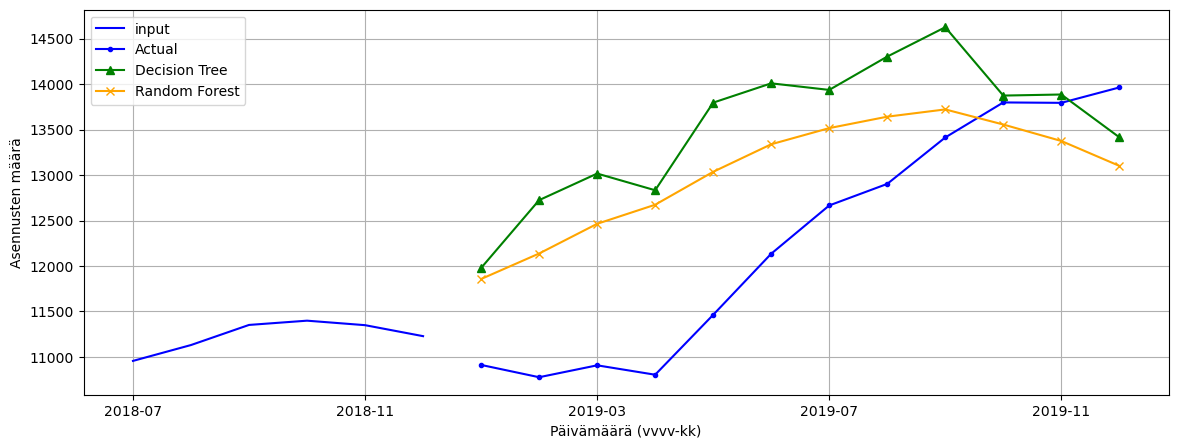

In [13]:
fig, ax = plt.subplots(figsize=(14, 5))

a = input_len
b = input_len + output_len

N = len(seq_df)

def format_date_2(x1, pos=None):
  thisind = np.clip(int(x1 + 0.5), 0, N - 1)
  return df_ML['year-month'].iloc[N - test_size + thisind]

ax.plot(np.arange(0, a, 1), X_test[0], 'b-', label='input')
ax.plot(np.arange(a, b, 1), y_test[0], marker='.', color='blue', label='Actual')
ax.plot(np.arange(a, b, 1), dt_seq_preds[0], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(a, b, 1), rf_seq_preds[0], marker='x', color='orange', label='Random Forest')

locator = mdates.AutoDateLocator(maxticks=8)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(format_date_2)
#fig.autofmt_xdate()
ax.set_xlabel('Päivämäärä (vvvv-kk)')
ax.set_ylabel('Asennusten määrä')
ax.legend()
ax.grid()
plt.show()


Tällä kertaa ennuste ei näytä suoraan kopioivan toteutunutta asennusmäärää. Ensivaikutelma herättää toiveita siitä, että malli voisi toimia siihen nähden hyvin, että data ei ole kovin säännöllistä ja on siten oletettavasti vaikeaa ennustaa. Toisaalta tässä voi olla kyse tuurista, että ennuste seuraa edes vähän toteutunutta määrää.

In [14]:
res = pd.DataFrame({'Actual': df_ML['count'].tail(12), 'Decision Tree': dt_seq_preds[0], 'Random Forest': rf_seq_preds[0]})
res


Actual  Decision Tree  Random Forest
2019-01  10912.600000        11978.2      11857.074
2019-02  10777.400000        12724.0      12137.260
2019-03  10908.200000        13016.2      12463.798
2019-04  10804.800000        12832.6      12673.510
2019-05  11463.400000        13795.8      13035.334
2019-06  12134.800000        14008.0      13338.214
2019-07  12665.600000        13935.6      13515.730
2019-08  12902.600000        14302.0      13641.390
2019-09  13413.000000        14624.8      13721.350
2019-10  13798.000000        13873.4      13555.260
2019-11  13793.500000        13885.2      13374.260
2019-12  13962.666667        13414.8      13100.796